In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.9.1
sys.version_info(major=3, minor=9, micro=7, releaselevel='final', serial=0)
matplotlib 3.5.2
numpy 1.23.0
pandas 1.4.3
sklearn 1.1.1
tensorflow 2.9.1
tensorflow.keras 2.9.0


In [24]:
imdb = keras.datasets.imdb
vocab_size = 10000  # #词典大小，仅保留训练数据中前10000个最经常出现的单词，舍弃低频单词（作为特殊字符处理）
index_from = 3  # index从1开始，截取的单词和对应索引,向后平移3个单位，空出0，1，2，3代表特殊字符
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size, index_from=index_from)

In [25]:
# train_data每个样本都是一个向量（不等长）
# train_labels的每个样本都是一个值，pos(positive)为1和neg(negative)为0

print(train_data.shape, train_labels.shape)  # (25000,) (25000,)
print(type(train_data), type(train_labels))  # <class 'numpy.ndarray'> <class 'numpy.ndarray'>
print(len(train_data), len(train_labels))  # 25000 25000
print(type(train_data[0]), type(train_labels[0]))  # <class 'list'> <class 'numpy.int64'> ndarray不支持不等长数组，list支持不等长列表
print(train_data[0], train_labels[0])
print(len(train_data[0]), train_labels[0].shape)  # 218 ()
print(test_data.shape, test_labels.shape)  # (25000,) (25000,)

(25000,) (25000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
25000 25000
<class 'list'> <class 'numpy.int64'>
[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283,

In [26]:
print(min([j for i in train_data for j in i]))  # 词的index是从1开始
print(min(train_labels), max(train_labels))  # 0 1
print(np.unique(train_labels))  # [0 1]

1
0 1
[0 1]


In [27]:
# 拿到数据集索引和单词的对应关系
word_index = imdb.get_word_index()
print(len(word_index))  # 88584 现准备只载入最高频的1万词
print(type(word_index))  # <class 'dict'>

88584
<class 'dict'>


In [28]:
# key是单词，value是索引编号
for key, value in word_index.items():
    print(key, value)
    break

fawn 34701


In [29]:
reverse_word_index = dict([(value, key) for key, value in word_index.items()])
print(type(reverse_word_index))  # <class 'dict'>
print(reverse_word_index.get(1))
print(reverse_word_index.get(0))

<class 'dict'>
the
None


In [30]:
# index_from偏移3
word_index = {key: (value + index_from) for key, value in word_index.items()}

In [31]:
# 多余槽位我们给与新的释义
word_index['<PAD>'] = 0  # padding填充的字符
word_index['<START>'] = 1  # 起始
word_index['<UNK>'] = 2  # 未找到就返回UNK未知，词频排名1万名后的词标记为UNK
word_index['<END>'] = 3  # 每个句子末尾
reverse_word_index = dict([(value, key) for key, value in word_index.items()])

In [32]:
def decode_review(text_ids):
    return ' '.join(reverse_word_index.get(word_id, '<UNK>') for word_id in text_ids)


decode_review(train_data[0])
decode_review(train_data[1])
decode_review(train_data[2])

"<START> this has to be one of the worst films of the 1990s when my friends i were watching this film being the target audience it was aimed at we just sat watched the first half an hour with our jaws touching the floor at how bad it really was the rest of the time everyone else in the theatre just started talking to each other leaving or generally crying into their popcorn that they actually paid money they had <UNK> working to watch this feeble excuse for a film it must have looked like a great idea on paper but on film it looks like no one in the film has a clue what is going on crap acting crap costumes i can't get across how <UNK> this is to watch save yourself an hour a bit of your life"

In [33]:
# 句子长度低于500会被补全，高于500会被截断
max_length = 500
train_data = keras.preprocessing.sequence.pad_sequences(
    train_data,  # list of list
    value=word_index['<PAD>'],  # 超出最大值的部分需填充的数据
    padding='post',  # post在后填充 pre在前填充
    maxlen=max_length)
test_data = keras.preprocessing.sequence.pad_sequences(
    test_data,
    value=word_index['<PAD>'],
    padding='post',
    maxlen=max_length)
print(train_data.shape)  # (25000, 500)
print(test_data.shape)  # (25000, 500)

(25000, 500)
(25000, 500)


In [34]:
print(train_data[0])
print(test_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [35]:
# 交叉熵损失
y_true = [[0, 1]]
y_pred = [[0.6, 0.3]]
loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)
print(loss)
print(loss.numpy())
print(loss.shape)
print(-(np.log(1 - 0.6) + np.log(0.3))/2)

tf.Tensor([1.0601315], shape=(1,), dtype=float32)
[1.0601315]
(1,)
1.0601317681000455


In [36]:
embedding_dim = 16  # 降维后每个词的向量维度 密集向量
batch_size = 128
# 稀疏矩阵到密集矩阵的过程叫embedding，也叫查表
model = keras.models.Sequential([
    # [max_length, vocab_size] 每行one-hot编码
    # [max_length, vocab_size] @ [vocab_size, embedding_dim] = [max_length, embedding_dim]
    keras.layers.Embedding(vocab_size,  # 词袋大小
                           embedding_dim, input_length=max_length),
    # 输出[batch_size, max_length, embedding_dim]
    # 全局平均值池化消除维度max_length变为[batch_size, embedding_dim]
    keras.layers.GlobalAveragePooling1D(),  #抽象上 让一个词表示整篇文章
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')])
print(model.summary())
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 500, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 64)                1088      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
print(10000*16)
print(16*64+64)
print(64*1+1)

160000
1088
65


In [38]:
print(model.variables)

[<tf.Variable 'embedding_3/embeddings:0' shape=(10000, 16) dtype=float32, numpy=
array([[-8.50819051e-04, -2.62744725e-05, -1.88692212e-02, ...,
         3.79449837e-02, -3.28703672e-02,  2.59172954e-02],
       [-1.17647648e-03, -4.43244092e-02,  3.56485359e-02, ...,
         2.64543779e-02,  1.83495171e-02, -1.36750937e-02],
       [-2.90280227e-02, -8.61221552e-03,  4.18451466e-02, ...,
         1.16060749e-02, -1.25065818e-02,  4.34998758e-02],
       ...,
       [ 1.11441016e-02,  4.79198210e-02,  4.97940220e-02, ...,
        -3.99131700e-03,  4.23131473e-02, -3.72671261e-02],
       [-1.45261511e-02, -8.95857811e-05,  3.68540026e-02, ...,
         1.02773905e-02,  1.91998519e-02, -1.37633309e-02],
       [-3.92074510e-03, -8.90124589e-04,  4.22508977e-02, ...,
        -2.79736649e-02,  4.72758152e-02,  2.88841017e-02]], dtype=float32)>, <tf.Variable 'dense_2/kernel:0' shape=(16, 64) dtype=float32, numpy=
array([[ 0.27124548, -0.09873629,  0.09722102, ..., -0.09768526,
         0.

In [39]:
from tensorflow.keras.utils import plot_model

plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [40]:
history = model.fit(train_data, train_labels,
                    epochs=30,
                    batch_size=batch_size,
                    validation_split=0.2)  # 训练集分划分为训练集和验证集的比例

Epoch 1/30
157/157 [==============================] - 2s 10ms/step - loss: 0.6863 - accuracy: 0.5810 - val_loss: 0.6539 - val_accuracy: 0.7634
Epoch 2/30
157/157 [==============================] - 1s 8ms/step - loss: 0.5419 - accuracy: 0.8013 - val_loss: 0.4284 - val_accuracy: 0.8528
Epoch 3/30
157/157 [==============================] - 1s 9ms/step - loss: 0.3507 - accuracy: 0.8765 - val_loss: 0.3369 - val_accuracy: 0.8704
Epoch 4/30
157/157 [==============================] - 1s 8ms/step - loss: 0.2760 - accuracy: 0.8964 - val_loss: 0.3041 - val_accuracy: 0.8820
Epoch 5/30
157/157 [==============================] - 1s 8ms/step - loss: 0.2364 - accuracy: 0.9137 - val_loss: 0.2904 - val_accuracy: 0.8870
Epoch 6/30
157/157 [==============================] - 1s 9ms/step - loss: 0.2074 - accuracy: 0.9258 - val_loss: 0.2844 - val_accuracy: 0.8898
Epoch 7/30
157/157 [==============================] - 1s 10ms/step - loss: 0.1859 - accuracy: 0.9324 - val_loss: 0.2876 - val_accuracy: 0.8880
Epoc

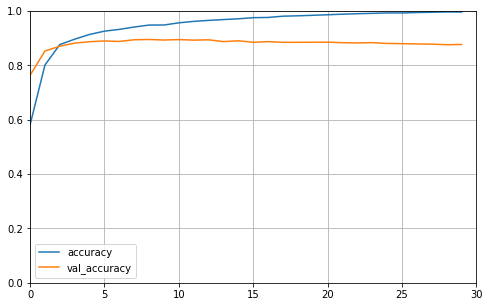

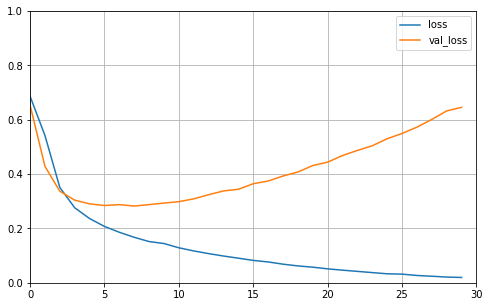

In [41]:
def plot_learning_curves(history, label, epochs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_' + label] = history.history['val_' + label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
plot_learning_curves(history, 'accuracy', 30, 0, 1)
plot_learning_curves(history, 'loss', 30, 0, 1)

In [42]:
model.evaluate(test_data,test_labels,batch_size=batch_size,verbose=0)

[0.6951668858528137, 0.8588799834251404]

In [43]:
model1=tf.keras.Sequential()
model1.add(tf.keras.layers.Embedding(1000,64,input_length=10))
input_array=np.random.randint(1000,size=(32,10))
model1.compile('rmsprop','mse')
output_array=model1.predict(input_array)
print(output_array.shape)

1/1 [==============================] - 0s 27ms/step
(32, 10, 64)
